In [1]:
import torch
from torch import nn, Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from typing import List, Dict, Union, Tuple, Optional, Any
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import itertools
import pickle


Creating Dataset Class

In [2]:
#Setting seeds for reproducibility and enforcing deterministic behaviour
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  

#Initializing tokenizer and mapping class labels to numerical values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'Financial Crime': 0,
          'Cybercrime': 1,
          'Drugs and Narcotics Trade': 2,
          'Violent Crime': 3,
          'Weapons Trade': 4
          }


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, mode: str = 'head') -> None:
        """
        Initializes the Dataset object.

        Parameters:
        - df (pd.DataFrame): DataFrame containing 'label' and 'text' columns.
        - mode (str): Mode for selecting text truncation approach for inputs > 512 tokens ('head', 'tail', 'middle', 'combine').

        Returns:
        None
        """
        self.labels: List[int] = [labels[label] for label in df['label']]
        self.texts: List[str] = [text for text in df['text']]
        self.mode: str = mode

    def classes(self) -> List[int]:
        """
        Returns the list of labels.

        Returns:
        List[int]: List of labels.
        """
        return self.labels

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns:
        int: Number of samples.
        """
        return len(self.labels)

    def get_batch_labels(self, idx: int) -> np.ndarray:
        """
        Returns the labels for a batch.

        Parameters:
        - idx (int): Index of the batch.

        Returns:
        np.ndarray: Array of labels for the batch.
        """
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx: int) -> Dict[str, Union[torch.Tensor, torch.Tensor]]:
        """
        Returns tokenized and processed inputs for a batch.

        Parameters:
        - idx (int): Index of the batch.

        Returns:
        Dict[str, Union[torch.Tensor, torch.Tensor]]: Dictionary containing 'input_ids' and 'attention_mask'.
        """
        text = self.texts[idx]

        inputs = tokenizer(text, max_length=None, truncation=True, return_tensors="pt")
        return inputs

    def __getitem__(self, idx: int) -> Tuple[Dict[str, torch.Tensor], np.ndarray]:
        """
        Returns a batch of data.

        Parameters:
        - idx (int): Index of the batch.

        Returns:
        Tuple[Dict[str, torch.Tensor], np.ndarray]: Tuple containing input data and labels for the batch.
        """
        batch_texts = self.get_batch_texts(idx)
        input_ids = batch_texts['input_ids']
        attention_mask = batch_texts['attention_mask']

        if input_ids.shape[1] > 512:
            if self.mode == 'head':  # take the initial 512 tokens
                input_ids = input_ids[:, :512]
                attention_mask = attention_mask[:, :512]
            elif self.mode == 'tail':  # take the last 512 tokens
                input_ids = input_ids[:, -512:]
                attention_mask = attention_mask[:, -512:]
            elif self.mode == 'middle':  # take the middle 512 tokens
                center = input_ids.shape[1] // 2
                input_ids = input_ids[:, center - 256:center + 256]
                attention_mask = attention_mask[:, center - 256:center + 256]
            else:  # combine first 256 and last 256
                input_ids = torch.cat((input_ids[:, :256], input_ids[:, -256:]), dim=1)
                attention_mask = torch.cat((attention_mask[:, :256], attention_mask[:, -256:]), dim=1)

        # add padding manually
        if input_ids.shape[1] < 512:
            padding = torch.zeros(input_ids.shape[0], 512 - input_ids.shape[1])
            input_ids = torch.cat((input_ids, padding), dim=1)
            attention_mask = torch.cat((attention_mask, padding), dim=1)

        return {'input_ids': input_ids, 'attention_mask': attention_mask}, self.get_batch_labels(idx)



Custom BERT model

In [3]:
class BertClassifier(nn.Module):
    def __init__(self, dropout: float = 0.1):
        """
        Initializes the BertClassifier.

        Parameters:
        - dropout (float): Dropout probability for the dropout layer.

        Returns:
        None
        """
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.gelu = nn.GELU()

    def forward(self, input_id: Tensor, mask: Tensor) -> Tensor:
        """
        Performs forward pass through the BertClassifier.

        Parameters:
        - input_id (Tensor): Tensor representing input IDs.
        - mask (Tensor): Tensor representing attention mask.

        Returns:
        Tensor: Final layer output.
        """
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.gelu(linear_output)

        return final_layer


Training and evaluating functions

In [4]:
def train(model: nn.Module,
        train_data: pd.DataFrame,
        val_data: pd.DataFrame,
        learning_rate: float,
        epochs: int,
        plot_graphs: bool = False,
        mode: str = 'combined',
        print_epochs: bool = False,
        early_stop: bool = True,
        use_scheduler: bool = True,
        custom_learning_rates: Optional[List[float]] = None) -> Optional[int]:
    """
    Trains a the BertClassifier model.

    Parameters:
    - model (nn.Module): The Bert model to be trained.
    - train_data (pd.DataFrame): Training data as a pandas DataFrame.
    - val_data (pd.DataFrame): Validation data as a pandas DataFrame.
    - learning_rate (float): Learning rate for the optimizer.
    - epochs (int): Number of training epochs.
    - plot_graphs (bool): Whether to plot training and validation graphs.
    - mode (str): Mode for selecting text truncation approach for inputs > 512 tokens ('head', 'tail', 'middle', 'combine').
    - print_epochs (bool): Whether to print training progress after each epoch.
    - early_stop (bool): Whether to enable early stopping.
    - use_scheduler (bool): Whether to use a learning rate scheduler.
    - custom_learning_rates (Optional[List[float]]): List of custom learning rates for each epoch.

    Returns:
    - Optional[int]: If early stopping is enabled, it returns the epoch at which training was stopped. Otherwise, returns None. --> for hyperparameter purposes
    """
    train, val = Dataset(train_data, mode=mode), Dataset(val_data, mode=mode)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(123))
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16, generator=torch.Generator().manual_seed(123))
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  #move the model to the device
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  #wrap the model


    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    scheduler = None
    if use_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

    best_val_balanced_acc = 0
    num_epochs_no_improvement = 0

    train_losses = []
    val_losses = []
    train_balanced_accuracies = []  
    val_balanced_accuracies = []  

    for epoch_num in range(epochs):
        model.train()
        total_loss_train = 0
        y_true, y_pred = [], []

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device, dtype=torch.long)
            input_id = train_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            _, predicted_labels = torch.max(output, dim=1)
            y_true.extend(train_label.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        train_balanced_acc = balanced_accuracy_score(y_true, y_pred)
        train_losses.append(total_loss_train / len(train_data))
        train_balanced_accuracies.append(train_balanced_acc)

        model.eval()
        total_loss_val = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device, dtype=torch.long)
                input_id = val_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                _, predicted_labels = torch.max(output, dim=1)
                y_true_val.extend(val_label.cpu().numpy())
                y_pred_val.extend(predicted_labels.cpu().numpy())

        val_balanced_acc = balanced_accuracy_score(y_true_val, y_pred_val)
        val_losses.append(total_loss_val / len(val_data))
        val_balanced_accuracies.append(val_balanced_acc)

        if use_scheduler:
            scheduler.step(val_balanced_acc)
        elif custom_learning_rates:
            current_learning_rate = custom_learning_rates[epoch_num]
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate

        if print_epochs:
            print(f'Epochs: {epoch_num + 1} | Train Loss: {train_losses[-1]:.3f} '
                  f'| Train Balanced Accuracy: {train_balanced_acc:.3f} '
                  f'| Val Loss: {val_losses[-1]:.3f} '
                  f'| Val Balanced Accuracy: {val_balanced_acc:.3f}')
        
        if val_balanced_acc > best_val_balanced_acc:
            best_val_balanced_acc = val_balanced_acc
            num_epochs_no_improvement = 0
        else:
            num_epochs_no_improvement += 1
        
        if early_stop: #early stopping if no improvement for 3 epochs
            if num_epochs_no_improvement >= 3:
                print(f'Stopping at Epoch {epoch_num + 1}')
                epoch_stop = epoch_num + 1
                return epoch_stop

    if plot_graphs:
        #plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

        #plot balanced accuracies
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_balanced_accuracies, label='Training Balanced Accuracy', color='blue')
        plt.plot(range(1, epochs + 1), val_balanced_accuracies, label='Validation Balanced Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Balanced Accuracy')
        plt.title('Training and Validation Balanced Accuracies')
        plt.legend()
        plt.show()


def evaluate(model: nn.Module,
    test_data: pd.DataFrame,
    mode: str = 'combined',
    metrics: bool = False) -> Optional[float]:

    """
    Evaluates the BertClassifier on test data.

    Parameters:
    - model (nn.Module): The Bert model to be evaluated.
    - test_data (pd.DataFrame): Test data as a pandas DataFrame.
    - mode (str): Mode for selecting text truncation approach for inputs > 512 tokens ('head', 'tail', 'middle', 'combine').
    - metrics (bool): Whether to print evaluation metrics.


    Returns:
    - Optional[float]: If metrics is False, returns the balanced accuracy (for hyperparameter tuning). Otherwise, returns None.
    """

    test = Dataset(test_data, mode=mode)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16, generator=torch.Generator().manual_seed(123))

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  #move the model to the device
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  #wrap the model


    model.eval()
    total_correct_by_class = [0] * len(labels)
    total_samples_by_class = [0] * len(labels)
    all_predictions = []
    all_labels = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device, dtype=torch.long)
              input_id = test_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

              output = model(input_id, mask)

              _, predicted_labels = torch.max(output, dim=1)

              all_predictions.extend(predicted_labels.cpu().numpy())
              all_labels.extend(test_label.cpu().numpy())
              

              for i in range(len(test_label)):
                  true_label = test_label[i].item()
                  predicted_label = predicted_labels[i].item()
                  total_samples_by_class[true_label] += 1
                  if true_label == predicted_label:
                      total_correct_by_class[true_label] += 1
    
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    total_acc = accuracy_score(all_labels, all_predictions)
        
    if metrics:
        print(f'Balanced Accuracy: {balanced_acc:.5f}') #basically macro recall
        print(f'(General) Accuracy: {total_acc:.5f}')

        class_recalls = recall_score(all_labels, all_predictions, labels=range(len(labels)), average=None)
        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f'F1 Score: {f1:.5f}\n')
        print(f'Class-specific metrics:')

        for i, label in enumerate(labels):
            class_recall = class_recalls[i]
            print(f'{label} Accuracy/Recall: {class_recall:.5f}')

        #confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  
        labels_list = list(labels.keys())
        conf_df = pd.DataFrame(conf_matrix, index=labels_list, columns=labels_list)

        #heatmap
        plt.figure(figsize=(10, 7))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(conf_matrix_norm, annot=conf_df, fmt='d', cmap=cmap, cbar_kws={'label': 'Percentage'})
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=45)
        plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)

        plt.show()

    else:
        return balanced_acc

Datasets

Train test split before lowercasing --> for data augmentation

In [5]:
#Train\val\test split is performed before the augmentation, stratified with 60-20-20 proportion.
df_trainval = pd.read_csv('data/trainval.csv', index_col= 0)
df_train = pd.read_csv('data/train.csv', index_col= 0)
df_test = pd.read_csv('data/test.csv', index_col=0)
df_val = pd.read_csv('data/val.csv', index_col=0)

#Lowercasing
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_trainval['text'] = df_trainval['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_val['text'] = df_val['text'].apply(lambda x: x.lower())

print(df_train.shape, df_trainval.shape, df_val.shape, df_test.shape)

(1158, 7) (1545, 7) (387, 7) (387, 7)


In [6]:
df_train.groupby('label')['text'].count()
#Needed to reach volume of FC --> 116 CC, 206 DN, 400 WT, 430 VC

label
Cybercrime                   346
Drugs and Narcotics Trade    256
Financial Crime              462
Violent Crime                 32
Weapons Trade                 62
Name: text, dtype: int64

Hyperparameter tuning

In [7]:
def save_results(result: Any, results_file: str) -> None:
    """
    Appends a result to existing results and saves them to a file.

    Parameters:
    - result (Any): The result to be saved.
    - results_file (str): File name for storing results.
    """
    existing_results = load_results(results_file)
    existing_results.append(result)
    with open(results_file, 'wb') as f:
        pickle.dump(existing_results, f)

def load_results(results_file: str) -> List[Any]:
    """
    Loads existing results from a file.

    Parameters:
    - results_file (str): File name for loading results.

    Returns:
    - List[Any]: List of existing results.
    """
    try:
        with open(results_file, 'rb') as f:
            existing_results = pickle.load(f)
        return existing_results
    except FileNotFoundError:
        return []

def train_and_evaluate(model: Any, lr: float, dropout: float, mode: str, train_data: pd.DataFrame, val_data: pd.DataFrame) -> Dict[str, Union[float, int, str]]:
    """
    Trains and evaluates a model with specified hyperparameters.

    Parameters:
    - model (Any): The Bert model to be trained and evaluated.
    - lr (float): Learning rate for optimization.
    - dropout (float): Dropout rate.
    - mode (str): Mode for selecting text truncation approach for inputs > 512 tokens ('head', 'tail', 'combined').
    - train_data (pd.DataFrame): Training data as a pandas DataFrame.
    - val_data (pd.DataFrame): Validation data as a pandas DataFrame.

    Returns:
    - Dict[str, Union[float, int, str]]: Dictionary containing results including lr, dropout, epochs, mode, and balanced accuracy.
    """
    model.train()
    epoch_num = train(model, train_data, val_data, lr, epochs=10, mode=mode, plot_graphs=False)

    model.eval()
    with torch.no_grad():
        balanced_acc = evaluate(model, val_data, mode=mode)

    return {'lr': lr, 'dropout': dropout, 'epochs': epoch_num, 'mode': mode, 'balanced_acc': balanced_acc}

import itertools
from typing import Dict, List, Tuple, Union

def grid_search(param_grid: Dict[str, List[Union[float, int, str]]], train_data: pd.DataFrame, val_data: pd.DataFrame, results_file: str) -> Tuple[Dict[str, Union[float, int, str]], float]:
    """
    Performs a grid search over specified hyperparameters and returns the best parameters and corresponding balanced accuracy.

    Parameters:
    - param_grid (Dict[str, List[Union[float, int, str]]]): Dictionary specifying the hyperparameter grid.
    - train_data (pd.DataFrame): Training data as a pandas DataFrame.
    - val_data (pd.DataFrame): Validation data as a pandas DataFrame.
    - results_file (str): File name for storing grid search results.

    Returns:
    - Tuple[Dict[str, Union[float, int, str]], float]: Best hyperparameters and corresponding balanced accuracy.
    """
    existing_results = load_results(results_file)

    best_score = 0
    best_params = {}

    for result in existing_results:
        try:
            score = result['balanced_acc']
            if score > best_score:
                best_score = score
                best_params = {'lr': result['lr'], 'dropout': result['dropout'], 'epochs': result['epochs'], 'mode': result['mode']}
        except (KeyError, TypeError):
            pass

    processed_combinations = set()

    for result in existing_results:
        try:
            combination = (result['lr'], result['dropout'], result['mode'])
            processed_combinations.add(combination)
        except (KeyError, TypeError):
            pass

    #Continue the search from the last processed combination
    combinations = itertools.product(param_grid['lr'], param_grid['dropout'], param_grid['mode'])

    for lr, dropout, mode in combinations:
        if (lr, dropout, mode) in processed_combinations:
            continue

        print(f"Processing combination: lr={lr}, dropout={dropout}, mode={mode}")

        model = BertClassifier(dropout=dropout)

        result = train_and_evaluate(model, lr, dropout, mode, train_data, val_data)

        save_results(result, results_file)

        if result['balanced_acc'] > best_score:
            best_score = result['balanced_acc']
            best_params = {'lr': lr, 'dropout': dropout, 'epochs': result['epochs'], 'mode': mode}

    return best_params, best_score

param_grid = {'lr': [5e-5, 4e-5, 3e-5, 2e-5], 'dropout': [0.1, 0.3, 0.5], 'mode': ['head', 'tail', 'combined']}
results_file = 'grid_search_result.pkl'


In [8]:
#start or continue the grid search
best_params, best_score = grid_search(param_grid, df_train, df_val, results_file)

print(f'Best Hyperparameters: {best_params}')
print(f'Best Balanced Accuracy: {best_score:.5f}')



Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'head'}
Best Balanced Accuracy: 0.94359


In [9]:
#Print top 5 results
existing_results = load_results('grid_search_result.pkl')
sorted_results = sorted(existing_results, key=lambda x: x['balanced_acc'], reverse=True)
for i in range(5):
    result = sorted_results[i]
    lr, dropout, mode = result['lr'], result['dropout'], result['mode']
    balanced_acc = result['balanced_acc']
    print(f"Top {i+1} --> Combination: lr={lr}, dropout={dropout}, mode={mode}, Balanced Accuracy: {balanced_acc:.3f}")

Top 1 --> Combination: lr=4e-05, dropout=0.3, mode=head, Balanced Accuracy: 0.944
Top 2 --> Combination: lr=5e-05, dropout=0.3, mode=head, Balanced Accuracy: 0.943
Top 3 --> Combination: lr=5e-05, dropout=0.1, mode=tail, Balanced Accuracy: 0.942
Top 4 --> Combination: lr=3e-05, dropout=0.1, mode=head, Balanced Accuracy: 0.941
Top 5 --> Combination: lr=2e-05, dropout=0.3, mode=tail, Balanced Accuracy: 0.941


Exploration of temperature value with tuned values

In [12]:
augmented_03temp = pd.read_csv('data/augmented_03temp_4bit.csv', index_col=0)
df_aug_temp_3_4bit = pd.concat([df_train[['text', 'label','snapshot_id']], augmented_03temp], ignore_index=True) 
df_aug_temp_3_4bit['text'] = df_aug_temp_3_4bit['text'].apply(lambda x: x.lower())

In [13]:
df_aug_temp_3_4bit.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


In [14]:
augmented_08temp = pd.read_csv('data/augmented_08temp_4bit.csv', index_col=0)
df_aug_temp_8_4bit = pd.concat([df_train[['text', 'label','snapshot_id']], augmented_08temp], ignore_index=True) 
df_aug_temp_8_4bit['text'] = df_aug_temp_8_4bit['text'].apply(lambda x: x.lower())

In [15]:
df_aug_temp_8_4bit.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'head'}

In [16]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [17]:
train(model, df_aug_temp_3_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True, use_scheduler=False)

100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Stopping at Epoch 6


6

In [18]:
evaluate(model, df_val, mode=mode)

0.9218881444499056

In [19]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [20]:
train(model, df_aug_temp_8_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True, use_scheduler= False)

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Stopping at Epoch 8


8

In [21]:
evaluate(model, df_val, mode=mode)

0.9372923403264609

In [24]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [26]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, early_stop=True, use_scheduler=False)

  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Stopping at Epoch 4


4

In [27]:
evaluate(model, df_val, mode=mode)

0.9151232635745142

Selected temperature based on Balanced Accuracy = 0.8

LLaMA2 Augmented Dataset

In [10]:
augmented_train = pd.read_csv('data/augmented_train.csv', index_col=0)
df_aug_train = pd.concat([augmented_train, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train['text'] = df_aug_train['text'].apply(lambda x: x.lower())

In [11]:
augmented_trainval = pd.read_csv('data/augmented_trainval.csv', index_col=0)
df_aug_trainval = pd.concat([augmented_trainval, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval['text'] = df_aug_trainval['text'].apply(lambda x: x.lower())

In [12]:
df_aug_train.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


Undersampled dataset

In [13]:
under = RandomUnderSampler(sampling_strategy="not minority", random_state=123) 
                     
df_under_train, _ = under.fit_resample(df_train, df_train[["label"]])
df_under_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,32,32,32,32,32,32
Drugs and Narcotics Trade,32,32,32,32,32,32
Financial Crime,32,32,32,32,32,32
Violent Crime,32,32,32,32,32,32
Weapons Trade,32,32,32,32,32,32


Comparing each approach:
1. BERT_B --> finetuning on original imbalanced dataset

In [20]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

#Best Combination --> lr=4e-05, dropout=0.3, mode=head, balanced accuracy: 0.944

  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 73/73 [00:33<00:00,  2.18it/s]


Epochs: 1 | Train Loss: 0.053 | Train Balanced Accuracy: 0.522 | Val Loss: 0.023 | Val Balanced Accuracy: 0.911


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epochs: 2 | Train Loss: 0.019 | Train Balanced Accuracy: 0.899 | Val Loss: 0.019 | Val Balanced Accuracy: 0.926


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epochs: 3 | Train Loss: 0.015 | Train Balanced Accuracy: 0.932 | Val Loss: 0.017 | Val Balanced Accuracy: 0.941


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epochs: 4 | Train Loss: 0.011 | Train Balanced Accuracy: 0.951 | Val Loss: 0.019 | Val Balanced Accuracy: 0.935


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


Epoch 00005: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 5 | Train Loss: 0.007 | Train Balanced Accuracy: 0.964 | Val Loss: 0.020 | Val Balanced Accuracy: 0.908


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


Epochs: 6 | Train Loss: 0.005 | Train Balanced Accuracy: 0.969 | Val Loss: 0.020 | Val Balanced Accuracy: 0.908


100%|██████████| 73/73 [00:31<00:00,  2.31it/s]


Epoch 00007: reducing learning rate of group 0 to 4.0000e-07.
Epochs: 7 | Train Loss: 0.004 | Train Balanced Accuracy: 0.971 | Val Loss: 0.020 | Val Balanced Accuracy: 0.912


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epochs: 8 | Train Loss: 0.004 | Train Balanced Accuracy: 0.971 | Val Loss: 0.020 | Val Balanced Accuracy: 0.912


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-08.
Epochs: 9 | Train Loss: 0.004 | Train Balanced Accuracy: 0.971 | Val Loss: 0.020 | Val Balanced Accuracy: 0.912


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


Epochs: 10 | Train Loss: 0.004 | Train Balanced Accuracy: 0.972 | Val Loss: 0.020 | Val Balanced Accuracy: 0.912


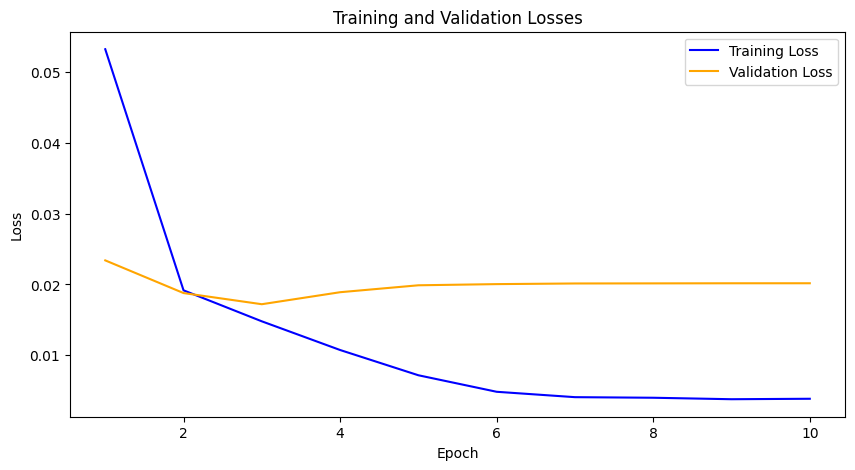

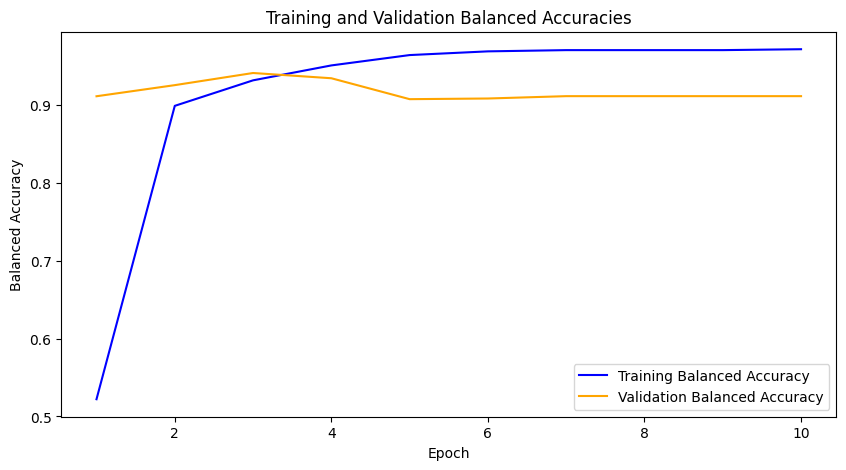

In [21]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, print_epochs=True, early_stop=False)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [21]:
EPOCHS = 3 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [22]:
train(model, df_train, df_test, LR, EPOCHS, mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

100%|██████████| 73/73 [00:31<00:00,  2.30it/s]


Balanced Accuracy: 0.90480
(General) Accuracy: 0.91731
F1 Score: 0.92161

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.95455
Cybercrime Accuracy/Recall: 0.86207
Drugs and Narcotics Trade Accuracy/Recall: 0.94118
Violent Crime Accuracy/Recall: 0.90909
Weapons Trade Accuracy/Recall: 0.85714


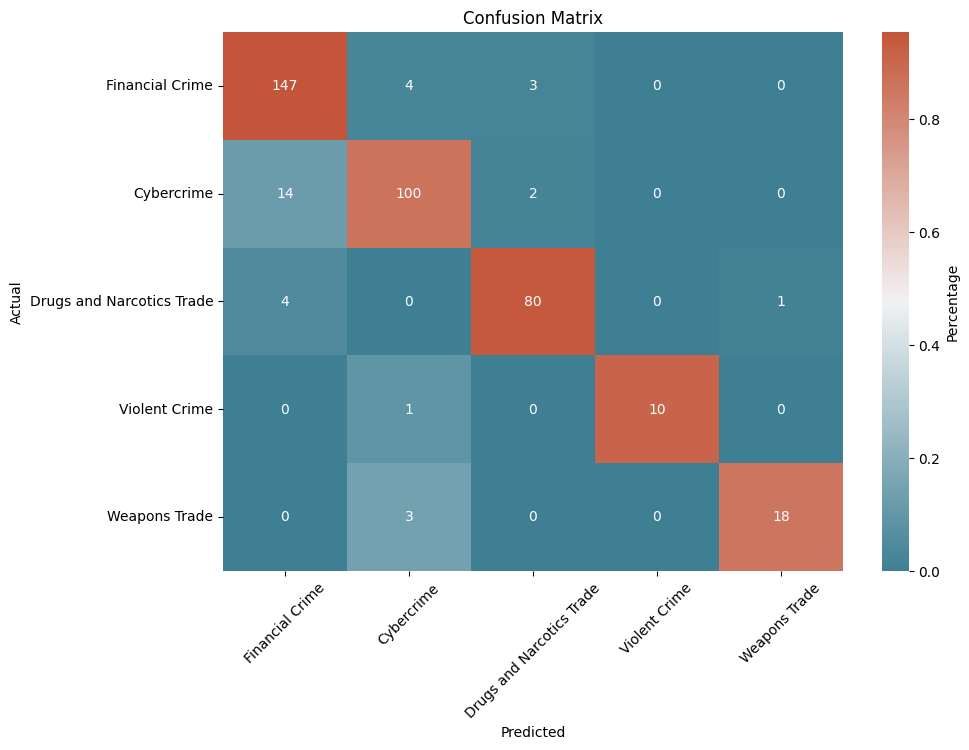

In [23]:
evaluate(model, df_test, mode=mode, metrics=True) 

2. BERT_US --> Finetuning on undersampled dataset

In [25]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epochs: 1 | Train Loss: 0.100 | Train Balanced Accuracy: 0.219 | Val Loss: 0.094 | Val Balanced Accuracy: 0.642


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epochs: 2 | Train Loss: 0.083 | Train Balanced Accuracy: 0.575 | Val Loss: 0.074 | Val Balanced Accuracy: 0.864


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epochs: 3 | Train Loss: 0.056 | Train Balanced Accuracy: 0.794 | Val Loss: 0.048 | Val Balanced Accuracy: 0.883


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epochs: 4 | Train Loss: 0.035 | Train Balanced Accuracy: 0.875 | Val Loss: 0.031 | Val Balanced Accuracy: 0.887


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epochs: 5 | Train Loss: 0.021 | Train Balanced Accuracy: 0.944 | Val Loss: 0.027 | Val Balanced Accuracy: 0.922


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epochs: 6 | Train Loss: 0.014 | Train Balanced Accuracy: 0.969 | Val Loss: 0.026 | Val Balanced Accuracy: 0.917


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Epochs: 7 | Train Loss: 0.011 | Train Balanced Accuracy: 0.969 | Val Loss: 0.027 | Val Balanced Accuracy: 0.927


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epochs: 8 | Train Loss: 0.008 | Train Balanced Accuracy: 0.981 | Val Loss: 0.029 | Val Balanced Accuracy: 0.921


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 9 | Train Loss: 0.005 | Train Balanced Accuracy: 0.994 | Val Loss: 0.028 | Val Balanced Accuracy: 0.920


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epochs: 10 | Train Loss: 0.004 | Train Balanced Accuracy: 0.994 | Val Loss: 0.029 | Val Balanced Accuracy: 0.918


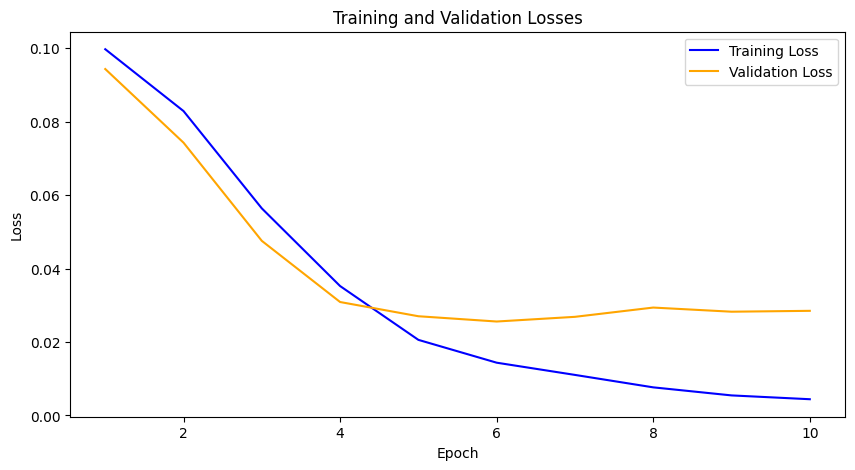

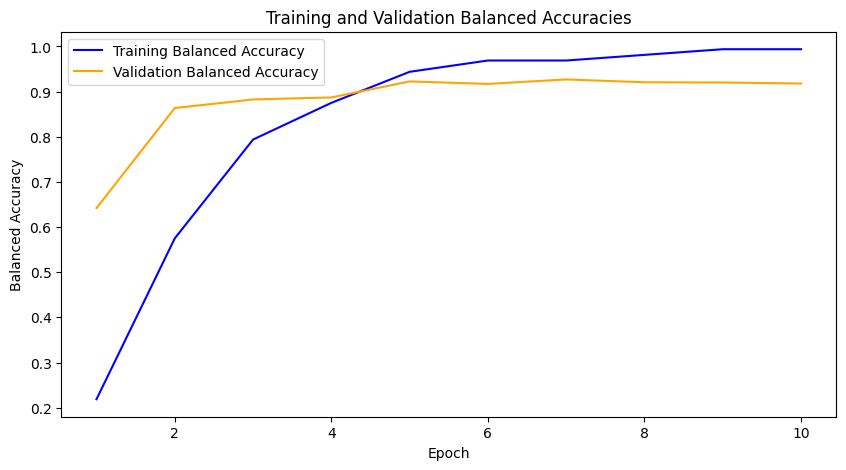

In [26]:
train(model, df_under_train, df_val, LR, EPOCHS,mode=mode, early_stop=False, print_epochs=True, plot_graphs=True)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [29]:
EPOCHS = 5 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [30]:
train(model, df_under_train, df_test, LR, EPOCHS,mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Balanced Accuracy: 0.92174
(General) Accuracy: 0.90439
F1 Score: 0.90157

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.91558
Cybercrime Accuracy/Recall: 0.87069
Drugs and Narcotics Trade Accuracy/Recall: 0.91765
Violent Crime Accuracy/Recall: 1.00000
Weapons Trade Accuracy/Recall: 0.90476


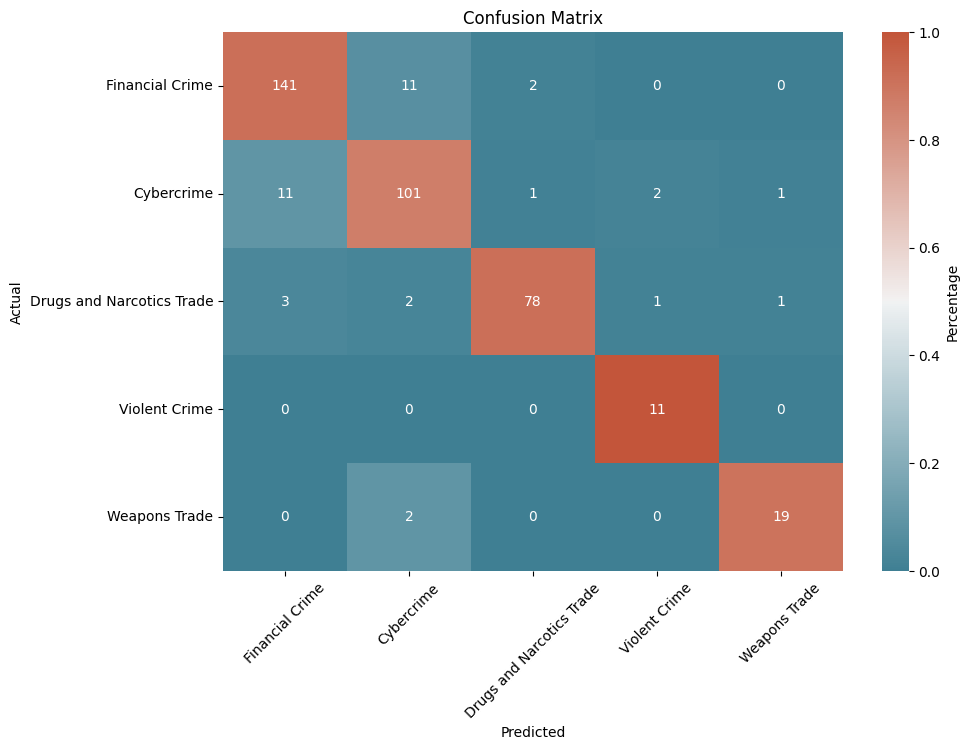

In [31]:
evaluate(model, df_test, mode=mode, metrics=True)

3. BERT_ZS --> Finetuning BERT on augmented dataset 

In [32]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 1 | Train Loss: 0.044 | Train Balanced Accuracy: 0.778 | Val Loss: 0.023 | Val Balanced Accuracy: 0.916


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 2 | Train Loss: 0.019 | Train Balanced Accuracy: 0.912 | Val Loss: 0.016 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 3 | Train Loss: 0.012 | Train Balanced Accuracy: 0.949 | Val Loss: 0.015 | Val Balanced Accuracy: 0.947


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 4 | Train Loss: 0.008 | Train Balanced Accuracy: 0.966 | Val Loss: 0.020 | Val Balanced Accuracy: 0.925


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epoch 00005: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 5 | Train Loss: 0.007 | Train Balanced Accuracy: 0.974 | Val Loss: 0.020 | Val Balanced Accuracy: 0.938


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 6 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.019 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epoch 00007: reducing learning rate of group 0 to 4.0000e-07.
Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.990 | Val Loss: 0.019 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 8 | Train Loss: 0.002 | Train Balanced Accuracy: 0.992 | Val Loss: 0.019 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-08.
Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.994 | Val Loss: 0.019 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.019 | Val Balanced Accuracy: 0.942


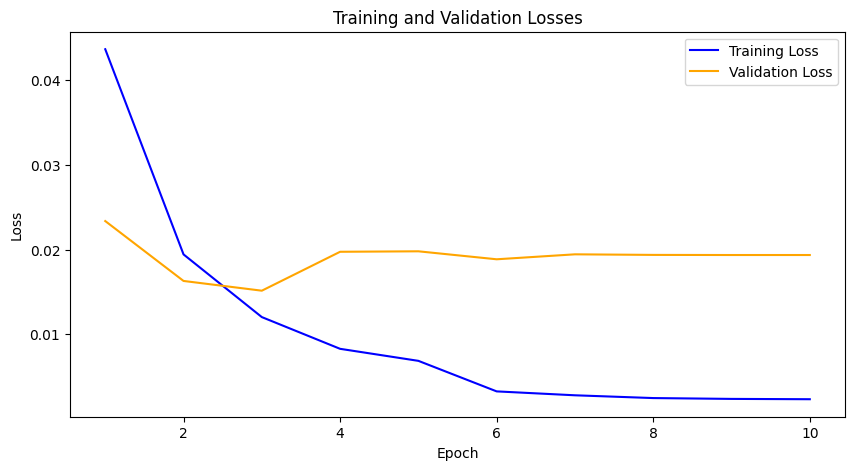

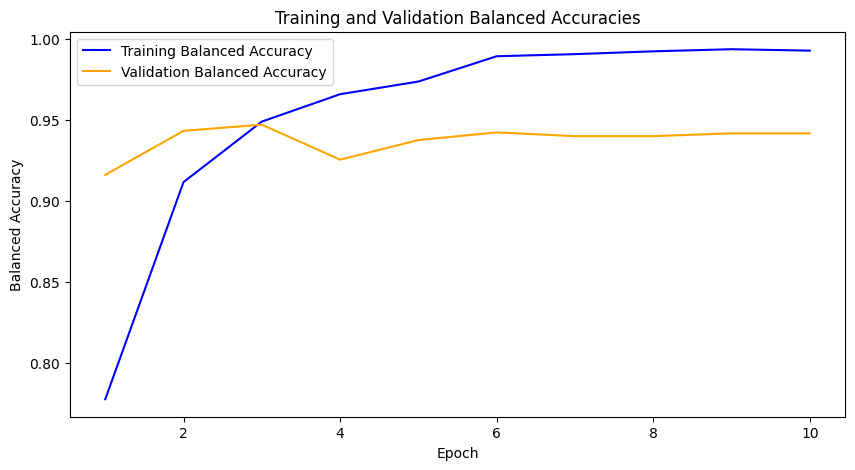

In [33]:
train(model, df_aug_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, early_stop=False, print_epochs=True)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [34]:
EPOCHS = 3 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [35]:
train(model, df_aug_train, df_test, LR, EPOCHS, mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Balanced Accuracy: 0.94539
(General) Accuracy: 0.93798
F1 Score: 0.95219

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.93506
Cybercrime Accuracy/Recall: 0.92241
Drugs and Narcotics Trade Accuracy/Recall: 0.96471
Violent Crime Accuracy/Recall: 1.00000
Weapons Trade Accuracy/Recall: 0.90476


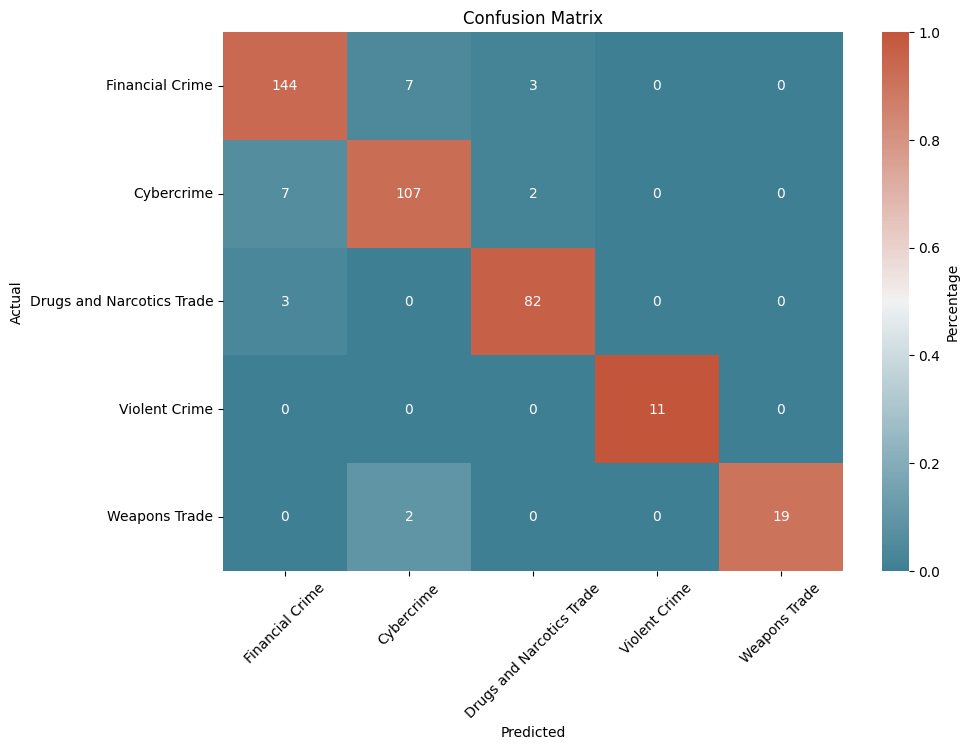

In [36]:
evaluate(model, df_test, mode=mode, metrics=True)

4. BERT_ZS_Q --> Finetuning BERT on dataset augmented with quantized LLaMA2

In [38]:
augmented_train_quant = pd.read_csv('data/augmented_train_quant.csv', index_col=0)
df_aug_train_quant = pd.concat([augmented_train_quant, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant['text'] = df_aug_train_quant['text'].apply(lambda x: x.lower())

In [40]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 1 | Train Loss: 0.045 | Train Balanced Accuracy: 0.765 | Val Loss: 0.022 | Val Balanced Accuracy: 0.926


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 2 | Train Loss: 0.022 | Train Balanced Accuracy: 0.899 | Val Loss: 0.019 | Val Balanced Accuracy: 0.938


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 3 | Train Loss: 0.013 | Train Balanced Accuracy: 0.949 | Val Loss: 0.017 | Val Balanced Accuracy: 0.941


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 4 | Train Loss: 0.008 | Train Balanced Accuracy: 0.971 | Val Loss: 0.017 | Val Balanced Accuracy: 0.941


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 5 | Train Loss: 0.006 | Train Balanced Accuracy: 0.977 | Val Loss: 0.018 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 6 | Train Loss: 0.006 | Train Balanced Accuracy: 0.975 | Val Loss: 0.020 | Val Balanced Accuracy: 0.939


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epoch 00007: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 7 | Train Loss: 0.005 | Train Balanced Accuracy: 0.981 | Val Loss: 0.021 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.991 | Val Loss: 0.020 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-07.
Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.994 | Val Loss: 0.020 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.994 | Val Loss: 0.020 | Val Balanced Accuracy: 0.940


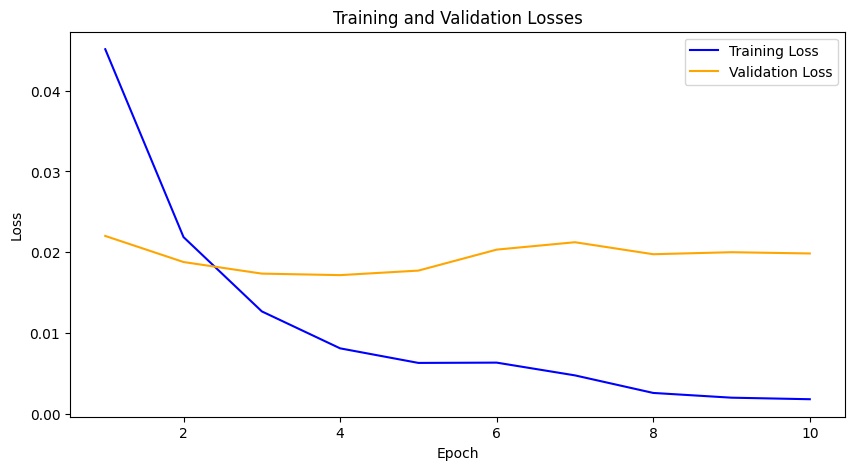

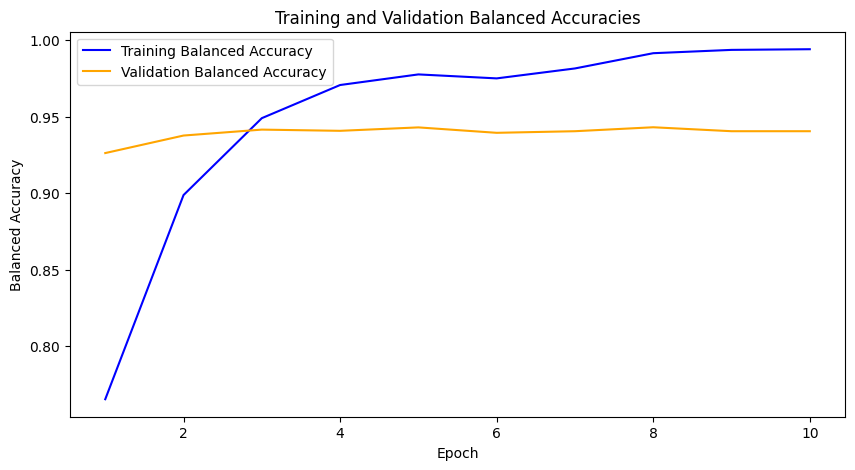

In [41]:
train(model, df_aug_train_quant, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [45]:
EPOCHS = 5 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [46]:
train(model, df_aug_train_quant, df_test, LR, EPOCHS, mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Balanced Accuracy: 0.94754
(General) Accuracy: 0.94057
F1 Score: 0.93265

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.92857
Cybercrime Accuracy/Recall: 0.93966
Drugs and Narcotics Trade Accuracy/Recall: 0.96471
Violent Crime Accuracy/Recall: 1.00000
Weapons Trade Accuracy/Recall: 0.90476


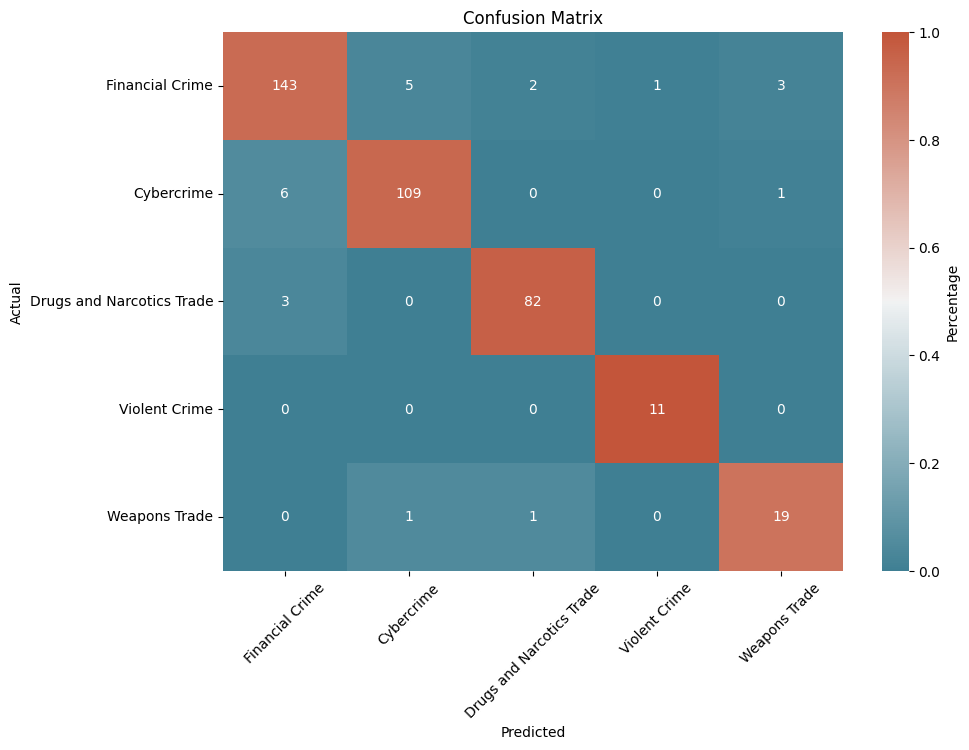

In [47]:
evaluate(model, df_test, mode=mode, metrics=True)

5. BERT_FS_Q --> Finetuning BERT on dataset augmented with few-shot prompting on quantized LLaMA2

In [16]:
augmented_train_quant_fs = pd.read_csv('data/augmented_train_quant_fs.csv', index_col=0)
df_aug_train_quant_fs = pd.concat([augmented_train_quant_fs, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant_fs['text'] = df_aug_train_quant_fs['text'].apply(lambda x: x.lower())

In [18]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 1 | Train Loss: 0.052 | Train Balanced Accuracy: 0.714 | Val Loss: 0.020 | Val Balanced Accuracy: 0.921


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 2 | Train Loss: 0.028 | Train Balanced Accuracy: 0.868 | Val Loss: 0.016 | Val Balanced Accuracy: 0.934


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 3 | Train Loss: 0.018 | Train Balanced Accuracy: 0.919 | Val Loss: 0.017 | Val Balanced Accuracy: 0.941


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 4 | Train Loss: 0.011 | Train Balanced Accuracy: 0.950 | Val Loss: 0.020 | Val Balanced Accuracy: 0.936


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epoch 00005: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 5 | Train Loss: 0.008 | Train Balanced Accuracy: 0.968 | Val Loss: 0.017 | Val Balanced Accuracy: 0.937


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.987 | Val Loss: 0.020 | Val Balanced Accuracy: 0.935


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epoch 00007: reducing learning rate of group 0 to 4.0000e-07.
Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.990 | Val Loss: 0.021 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.990 | Val Loss: 0.021 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-08.
Epochs: 9 | Train Loss: 0.003 | Train Balanced Accuracy: 0.991 | Val Loss: 0.021 | Val Balanced Accuracy: 0.934


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 0.992 | Val Loss: 0.021 | Val Balanced Accuracy: 0.934


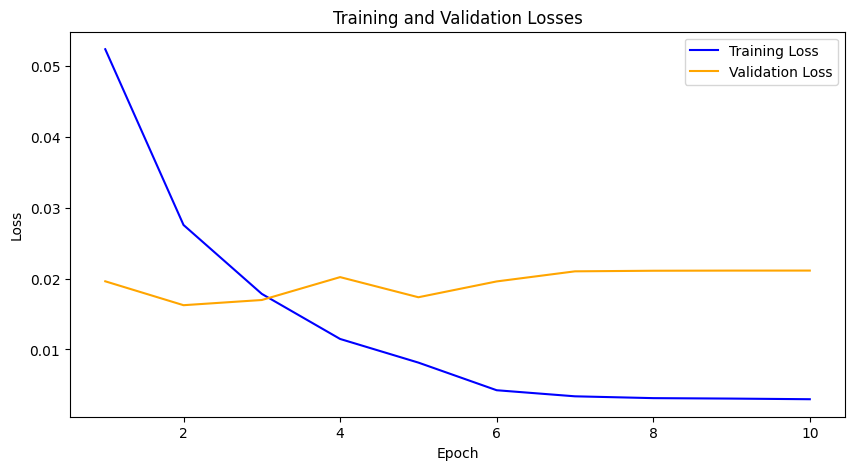

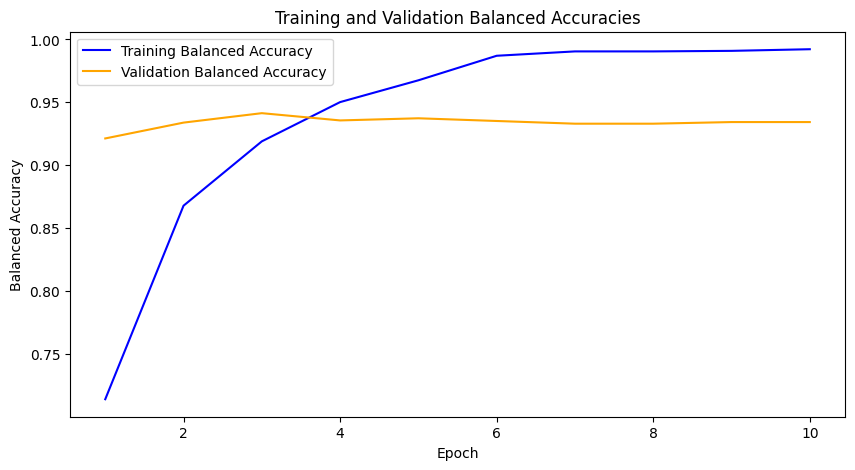

In [19]:
train(model, df_aug_train_quant_fs, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [20]:
EPOCHS = 3 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [21]:
train(model, df_aug_train_quant_fs, df_test, LR, EPOCHS, mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Balanced Accuracy: 0.93931
(General) Accuracy: 0.94057
F1 Score: 0.94992

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.93506
Cybercrime Accuracy/Recall: 0.93966
Drugs and Narcotics Trade Accuracy/Recall: 0.96471
Violent Crime Accuracy/Recall: 1.00000
Weapons Trade Accuracy/Recall: 0.85714


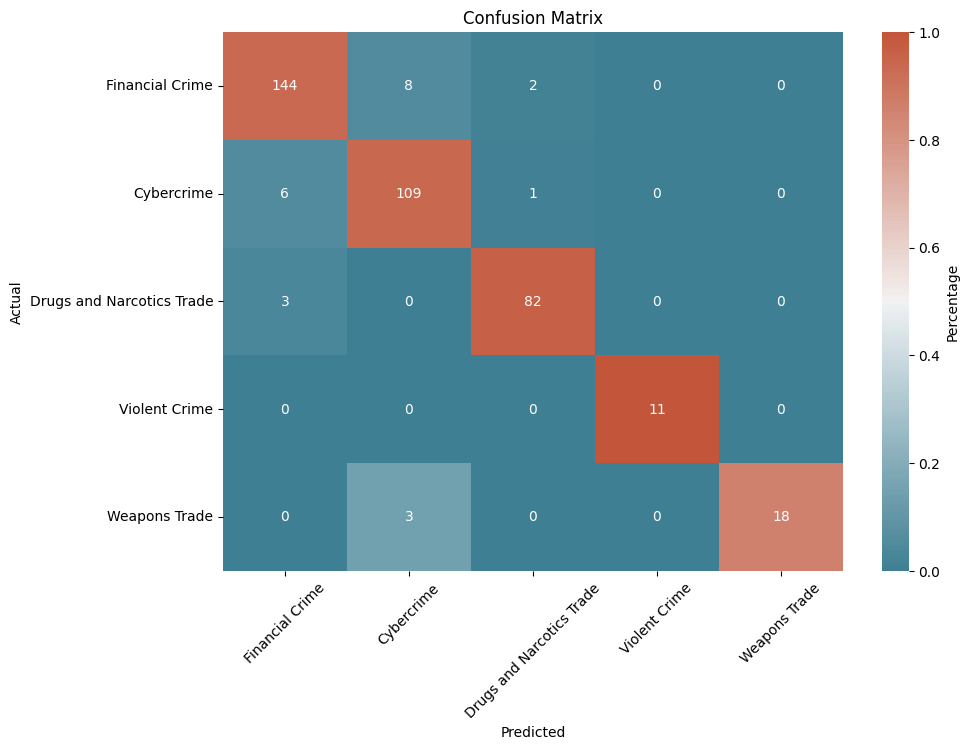

In [22]:
evaluate(model, df_test, mode=mode, metrics=True)

5. BERT_ZS_Q_chat --> Finetuning BERT on dataset augmented by quantized LLaMA2-Chat

In [56]:
augmented_train_quant_chat = pd.read_csv('data/augmented_train_quant_chat.csv', index_col=0)
df_aug_train_quant_chat = pd.concat([augmented_train_quant_chat, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant_chat['text'] = df_aug_train_quant_chat['text'].apply(lambda x: x.lower())

In [ ]:
augmented_trainval_quant_chat = pd.read_csv('data/augmented_trainval_quant_chat.csv', index_col=0)
df_aug_trainval_quant_chat = pd.concat([augmented_trainval_quant_chat, df_trainval[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval_quant_chat['text'] = df_aug_trainval_quant_chat['text'].apply(lambda x: x.lower())

In [58]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 1 | Train Loss: 0.038 | Train Balanced Accuracy: 0.806 | Val Loss: 0.021 | Val Balanced Accuracy: 0.929


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 2 | Train Loss: 0.015 | Train Balanced Accuracy: 0.940 | Val Loss: 0.017 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 3 | Train Loss: 0.010 | Train Balanced Accuracy: 0.960 | Val Loss: 0.015 | Val Balanced Accuracy: 0.952


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 4 | Train Loss: 0.008 | Train Balanced Accuracy: 0.966 | Val Loss: 0.018 | Val Balanced Accuracy: 0.931


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epoch 00005: reducing learning rate of group 0 to 4.0000e-06.
Epochs: 5 | Train Loss: 0.007 | Train Balanced Accuracy: 0.966 | Val Loss: 0.018 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.984 | Val Loss: 0.016 | Val Balanced Accuracy: 0.948


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epoch 00007: reducing learning rate of group 0 to 4.0000e-07.
Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.986 | Val Loss: 0.016 | Val Balanced Accuracy: 0.948


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.988 | Val Loss: 0.016 | Val Balanced Accuracy: 0.948


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epoch 00009: reducing learning rate of group 0 to 4.0000e-08.
Epochs: 9 | Train Loss: 0.003 | Train Balanced Accuracy: 0.988 | Val Loss: 0.016 | Val Balanced Accuracy: 0.948


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.016 | Val Balanced Accuracy: 0.948


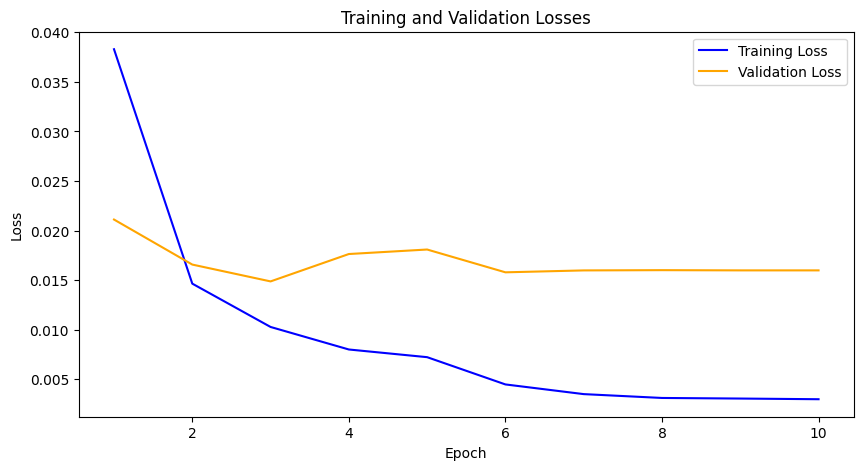

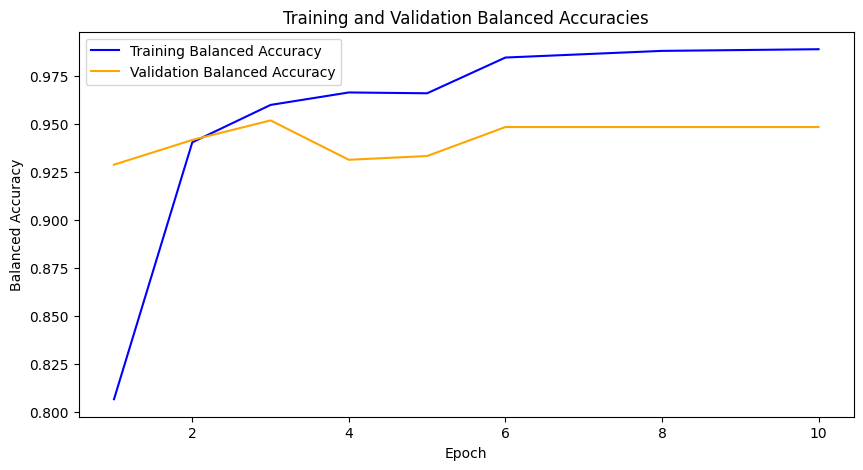

In [59]:
train(model, df_aug_train_quant_chat, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)
#First we determine number of epochs for each dataset, reducing LR on plateau

In [63]:
EPOCHS = 3 #optimal
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [64]:
train(model, df_aug_train_quant_chat, df_test, LR, EPOCHS, mode=mode, early_stop=False, use_scheduler=False)
#Then we retrain with optimal epochs and with reduced LR if needed

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Balanced Accuracy: 0.95077
(General) Accuracy: 0.94574
F1 Score: 0.95769

Class-specific metrics:
Financial Crime Accuracy/Recall: 0.94156
Cybercrime Accuracy/Recall: 0.93103
Drugs and Narcotics Trade Accuracy/Recall: 0.97647
Violent Crime Accuracy/Recall: 1.00000
Weapons Trade Accuracy/Recall: 0.90476


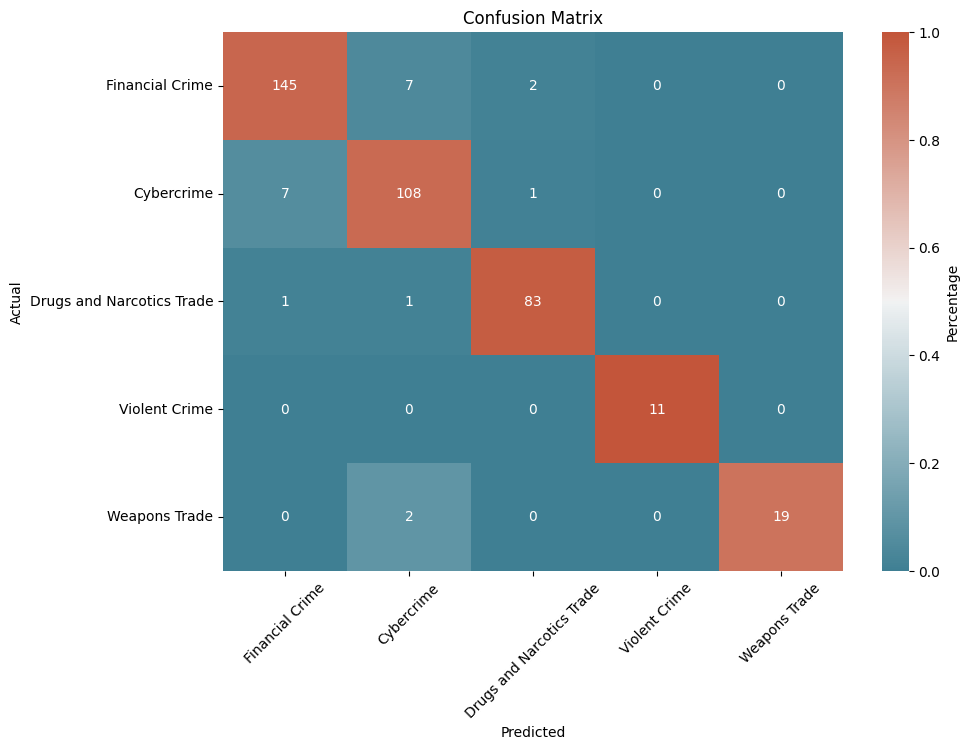

In [65]:
evaluate(model, df_test, mode=mode, metrics=True)